# Charging the data

Notebook showing how to charge and prepare the data to be used in the training of the neural network.

## 1. Import libraries

In [1]:
import random

import numpy as np

import pandas as pd

from skimage import filters, io, img_as_ubyte
from skimage.filters import median
from skimage.morphology import disk

from skimage.metrics import structural_similarity as ssim
from scipy.interpolate import interp1d, RegularGridInterpolator,make_interp_spline
from scipy.integrate import simpson
from scipy.ndimage import convolve1d
from scipy.signal import fftconvolve

from astropy.io import fits
from astropy.constants import c, e, m_e
from astropy import units as u

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse

import torch
from torchvision import transforms

import os

from tqdm import tqdm 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pathlib import Path

In [2]:
plt.rcParams.update({
  'axes.titlesize': 'x-large',  # heading 1
  'axes.labelsize': 'large',   # heading 2
  'xtick.labelsize': 'medium',         # fontsize of the ticks
  'ytick.labelsize': 'medium',         # fontsize of the ticks
  'font.family': 'serif',        # Font family
  'text.usetex': False,          # Do not use LaTeX for text rendering
  'figure.figsize': (10, 8),     # Default figure size
  'savefig.dpi': 300,            # High resolution for saving figures
  'savefig.format': 'png',       # Default format for saving figures
  'legend.fontsize': 'small',  # Font size for legends
  'lines.linewidth': 2,          # Line width for plots
  'lines.markersize': 8,         # Marker size for plots,
  'axes.formatter.useoffset': False,  # Disable offset
  'axes.formatter.use_mathtext': True,  # Use scientific notation
  'axes.formatter.limits': (-3, 4),  # Use scientific notation for values over 10^2
  'axes.labelsize': 'large',     # Font size for axes labels
  'figure.titlesize': 'xx-large', # Font size for suptitles (heading 1)
  'axes.formatter.use_locale': False  # Do not use locale settings
})


## 2. Atmospheric parameters

### 2.1 Charge the raw data

Define the path to the data for a testing file.

In [3]:
images_output = Path("../thesis_images")
if not os.path.exists(images_output):
    os.makedirs(images_output)

In [4]:
ptm = Path("/scratchsan/observatorio/juagudeloo/data")
filename = "112000"

nlam = 300 #this parameter is useful when managing the Stokes parameters #wavelenght interval - its from 6300 amstroengs in steps of 10 amstroengs
nx = 480 #width axis
ny = 480 #height axis
nz = 256 #geometrical height axis

Charge the data corresponding to temperature, magnetic field and velocity

In [5]:
# Path to the geometry data
geom_path = ptm / "geom_height"

print(f"""
        ######################## 
        Reading {filename} MuRAM data...
        ######################## 
              """)
# Load atmospheric parameters data
mtpr = np.load(geom_path / f"mtpr_{filename}.npy").flatten()
mvzz = np.load(geom_path / f"mvzz_{filename}.npy")
mbzz = np.load(geom_path / f"mbzz_{filename}.npy")

# # Magnetic field to Gauss
coef = np.sqrt(4.0*np.pi) #cgs units conversion
mbzz = mbzz*coef

# Array of atmospheric parameters
muram_box = np.array([mtpr, mvzz, mbzz])
muram_box = np.moveaxis(muram_box, 0, -1)
muram_box = np.reshape(muram_box, (nx, nz, ny, muram_box.shape[-1]))
muram_box = np.moveaxis(muram_box, 1, 2)
print("The muram_box.shape is:", muram_box.shape)


        ######################## 
        Reading 112000 MuRAM data...
        ######################## 
              
The muram_box.shape is: (480, 480, 256, 3)


Let's visualize the quantities for an specific height.

In [6]:
domain_heights = np.array(range(0, 256)) * 10 # Height in km
pixel_size_km = 25  # km per pixel

quantities = [
    (0, r"$T$", "K", "hot"),
    (1, r"$v_{\text{LOS}}$", "km/s", "bwr_r"),
    (2, r"$B_{\text{LOS}}$", "G", "PiYG"),
]

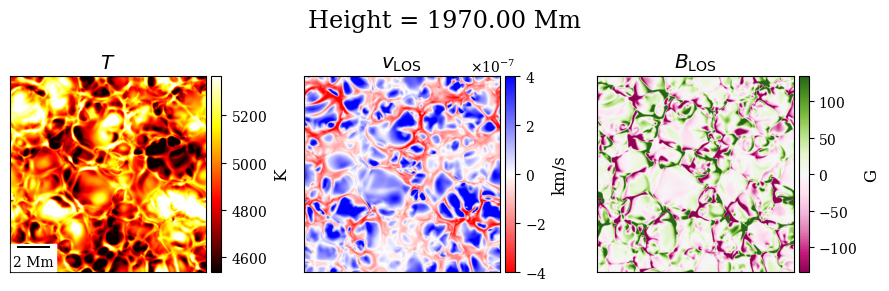

In [7]:
# Calculate the scale for the image
scale_bar = ScaleBar(pixel_size_km, "km", location="lower left")

height_pix = 197
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
fig.suptitle(f"Height = {domain_heights[height_pix]:.2f} Mm")

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
  data = muram_box[..., height_pix, param_idx]
  if title in [r"$v_{\text{LOS}}$"]:
    data /= 1e5
  if title in [r"$v_{\text{LOS}}$", r"$B_{\text{LOS}}$"]:
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
    vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
  else:
    orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
    vmin = orig_q5
    vmax = orig_q95

  iax = ax[i]
  im = iax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  iax.set_title(title)
  iax.set_xticks([])
  iax.set_yticks([])

  if i == 0:
    iax.add_artist(scale_bar)

  divider = make_axes_locatable(iax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax, label=unit)

plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_height_with_scalebar.png", dpi=300)
plt.show()


### 2.2 Optical Depth Stratification

Once we have the respective quantities charged, we would like to stratify the magnitudes with respect to logarithm of optical depth nodes $\log \tau$ for a comparison of the results with real data. Let's do it with just one pixel. The nodes we are gonna use correspond to the [MODEST dataset](https://www.aanda.org/articles/aa/abs/2024/07/aa49269-24/aa49269-24.html), which values are $\log \tau = 0, -0.8, -2.0$. Then, we are going to use 21 nodes from $\log \tau = -2.0$ to $\log \tau = 0$ with $\Delta \tau = 1$

In [8]:
 # Load the pressure
eos = np.fromfile(os.path.join(geom_path,  f"eos.{filename}"), dtype=np.float32)
eos = eos.reshape((2, nx, nz, ny), order = "C")
mpre = eos[1]
mpre = np.moveaxis(mpre, 1, 2)  # Pressure array to be used in the calculation of the optical depth
del eos

For doing the stratification corresponding to optical depth, we will use the following calculation
\begin{equation}
    \tau(z;T,P) = \int_{z_{\text{max}}}^{z} \kappa(T,P) \log(\rho) dz
\end{equation}
which correspond to the calculation of the optical depth parting from the opacity values multiplied by the volumetric density of the gas. This calculation correspond to the assumption of parallel atmospheres that can be applied on the photosphere thanks to it's behaviour that can be described aproximately through local thermodynamic equilibrium (LTE).

To this purpose we'll do the spline interpolation of the values corresponding to the Rosseland opacity related to specific values of Temperature and pressure

In [9]:
 # Upload the opacity data
tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                5.05, 5.10, 5.15, 5.20, 5.25, 5.30]) #log(T) in K

tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.]) #log(P) in dyne/cm^2

df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)
df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
temp_indices = df_kappa["Temperature index" ].unique()
press_indices = df_kappa["Pressure index"].unique()
opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values

Tk = tab_T[temp_indices]
Pk = tab_p[press_indices]
K = opacity_values

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1376826/2204471890.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_kappa = pd.read_csv('../csv/kappa.0.dat', sep='\s+', header=None)


Let's check that the temperature and pressure values we have in our dataset are inside the limits of our opacity temperature and pressure ranges.

In [10]:
def limit_values(data, min_val, max_val):
    new_data = np.clip(data, min_val+0.00001, max_val-0.00001)
    return new_data
                
T_log = np.log10(muram_box[..., 0]) 
P_log = np.log10(mpre) 
T_log = limit_values(T_log, Tk.min(), Tk.max())
P_log = limit_values(P_log, Pk.min(), Pk.max())
PT_log = np.stack((P_log.flatten(), T_log.flatten()), axis=-1)

Define the interpolator for obtaining the corresponding opacity values to our simulation distribution of temperature and pressure.

In [11]:
kappa_interp = RegularGridInterpolator((Pk,Tk), K, method="linear")

Now, let's apply the interpolation and create an array for the $\kappa\log(\rho)$ distribution.

In [12]:
kappa_rho = np.zeros_like(muram_box[..., 0])
kappa_rho = kappa_interp(PT_log)
kappa_rho = kappa_rho.reshape(muram_box[...,0].shape)
kappa_rho = np.multiply(kappa_rho, muram_box[..., 1])

Finally, let's integrate for each pixel under the parallel-plane atmosphere assumption

In [13]:
#Optical depth calculation
logtau_name = f"logtau_{filename}.npy"
if not os.path.exists(geom_path / logtau_name): #In case the optical depth has not been calculated yet
    tau = np.zeros_like(kappa_rho)
    dz = 1e6 # 10 km -> 1e6 cm
    tau[:,:,nz-1] = 1e-5

    print("Calculating optical depth...")
    for iz in tqdm(range(1,nz)):
        for ix in range(nx):
            for iy in range(ny):
                kpz = kappa_rho[ix,iy,nz-1-iz:]
                tau[ix,iy,nz-1-iz] = simpson(y = kpz, 
                                    dx = dz)
                
    muram_logtau = np.log10(tau)
    np.save(geom_path / logtau_name, muram_logtau)
    
else: #For visualization is better to load the optical depth values from the file for fast demonstration
    muram_logtau = np.load(geom_path / logtau_name)

Now that we have the logtau distribution of values, we will interpolate over each of the pixels to obtain the three nodes we are interested in.

##

In [14]:
#New logtau nodes
new_logtau = np.arange(-2.0,0.1,0.1)
n_logtau = new_logtau.shape[0]
print("The number of optical depths is:", n_logtau)

The number of optical depths is: 21


For each quantity we must interpolate over each of the simulations surface pixels to obtain their values in each of the three nodes.

In [15]:
opt_path = ptm / "opt_depth"

In [16]:
#Pixel by pixel iteration

#1. Atmospheric quantities iteration
atm_to_logtau = np.zeros((nx,ny,n_logtau,muram_box.shape[-1]))
for imur in range(muram_box.shape[-1]):
    #2. Pixel iteration
    geom_atm = muram_box[..., imur]
    new_muram_quantity = np.zeros((nx, ny, n_logtau))

    for ix in tqdm(range(nx)):
        for iy in range(ny):
            # Create and apply interpolation function directly
            mapper = interp1d(
                x=muram_logtau[ix, iy, :], 
                y=geom_atm[ix, iy, :], 
                kind="linear", 
                bounds_error=False, 
                fill_value="extrapolate"
            )
            new_muram_quantity[ix, iy, :] = mapper(new_logtau)
    atm_to_logtau[...,imur] = new_muram_quantity
muram_box = atm_to_logtau

100%|██████████| 480/480 [00:06<00:00, 69.95it/s]


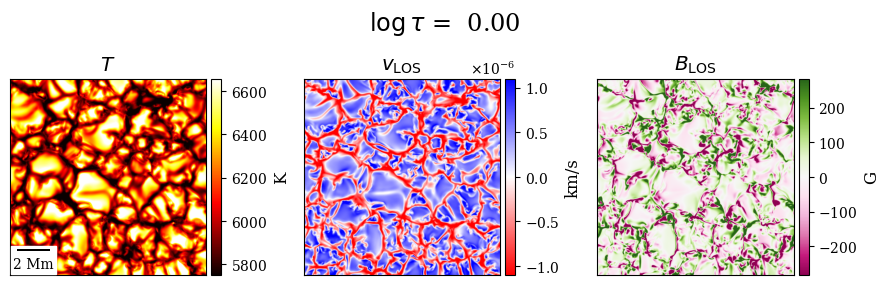

In [17]:
height_pix = -1
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
fig.suptitle(r"$\log \tau$" + f" = {new_logtau[height_pix]: 0.2f}")

for i, (param_idx, title, unit, cmap) in enumerate(quantities):
    data = muram_box[..., height_pix, param_idx]
    if title in [r"$v_{\text{LOS}}$"]:
        data /= 1e5
    if title in [r"$v_{\text{LOS}}$", r"$B_{\text{LOS}}$"]:
        orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
        vmin = -orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else orig_q5
        vmax = orig_q95 if np.abs(orig_q95) > np.abs(orig_q5) else -orig_q5
    else:
        orig_q5, orig_q95 = np.quantile(data, [0.05, 0.95])
        vmin = orig_q5
        vmax = orig_q95

    iax = ax[i]
    im = iax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    iax.set_title(title)
    iax.set_xticks([])
    iax.set_yticks([])

    if i == 0:
        scale_bar = ScaleBar(pixel_size_km, "km", location="lower left")
        iax.add_artist(scale_bar)

    divider = make_axes_locatable(iax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, label=unit)

plt.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "muram_box_fixed_opt_depth.png", dpi=300)
plt.show()


### 2.3 Atmospheric magnitudes max-min scaling

For the data to be treated by the neural network models, it is necessary to scale it. First, let's check the values of the magnitudes so that we are sure they were correctly scaled.

In [18]:
print(f"""
MAX VALUES:
mtpr max = {np.max(muram_box[...,0])}
mvzz max = {np.max(muram_box[...,1])}
mbzz max = {np.max(muram_box[...,2])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(muram_box[...,0])}
mbzz min = {np.min(muram_box[...,1])}
mvzz min = {np.min(muram_box[...,2])}
    """) 


MAX VALUES:
mtpr max = 6928.604804785236
mvzz max = 0.18087845978087078
mbzz max = 4718.879840526708
    

MIN VALUES:
mtpr min = 3703.3035574384776
mbzz min = -0.15720437454541333
mvzz min = -4168.992498949681
    


Now, let's define the scaling factors. For the Stokes parameters we will normalize by the continuum of the intensity, while for the atmospheric magnitudes we will use scale factors determined in terms of the mean maximum and minimum values of each magnitude along all the steps of the simulation. This study is shown [in this other notebook](./Check_data.ipynb).

In [19]:
#Atmosphere magnitudes scale factors
phys_maxmin = {}
phys_maxmin["T"] = [2e4, 0]
phys_maxmin["V"] = [1e6, -1e6]
phys_maxmin["B"] = [3e3, -3e3]

Let's define a minmax normalizing function.

In [20]:
def norm_func(arr, maxmin):
    max_val = maxmin[0]
    min_val = maxmin[1]
    return (arr-min_val)/(max_val-min_val)

Apply the scaling function on the muram data

In [21]:
scaled_atm = np.zeros_like(muram_box)
#Atmosphere magnitudes normalization
scaled_atm[...,0] = norm_func(muram_box[...,0], phys_maxmin["T"])
scaled_atm[...,1] = norm_func(muram_box[...,1], phys_maxmin["V"])
scaled_atm[...,2] = norm_func(muram_box[...,2], phys_maxmin["B"])

Let's check the new maximum and minimum values.

In [22]:
print(f"""
MAX VALUES:
mtpr max = {np.max(scaled_atm[...,:,:,0])}
mvzz max = {np.max(scaled_atm[...,:,:,1])}
mbzz max = {np.max(scaled_atm[...,:,:,2])}
    """)

print(f"""
MIN VALUES:
mtpr min = {np.min(scaled_atm[...,:,:,0])}
mbzz min = {np.min(scaled_atm[...,:,:,1])}
mvzz min = {np.min(scaled_atm[...,:,:,2])}
""")


MAX VALUES:
mtpr max = 0.34643024023926183
mvzz max = 0.5000000904392299
mbzz max = 1.286479973421118
    

MIN VALUES:
mtpr min = 0.18516517787192388
mbzz min = 0.49999992139781274
mvzz min = -0.1948320831582802



## 3. Stokes parameters

### 3.1 Charge the Stokes parameters

Having the atmosphere magnitudes charged, we need to charge now the radiation information contained in the Stokes parameters generated for our simulation. Specifically, we are just going to use the Stokes $I$ and Stokes $V$.

In [23]:
stokes = np.load(ptm / "stokes" / f"{filename}_prof.npy")
stokes = np.array([stokes[...,0], stokes[...,3]])
stokes = np.transpose(stokes, (1, 2, 3, 0))
print("stokes shape", stokes.shape)

stokes shape (480, 480, 300, 2)


The wavelength points generated from the simulation are $300$ spectral points of $0.01\,\text{\AA}$ beginning from $6300.5\,\text{\AA}$, containing the FeI spectral lines $6301.5\,\text{\AA}$ and $ 6302.5\,\text{\AA}$.

In [24]:
wl = np.arange(6300.5, 6303.5, 0.01)
print(f"Wavelengths from {wl[0]} to {wl[-1]} in steps of {np.round(wl[1] - wl[0], 2)} nm")

Wavelengths from 6300.5 to 6303.490000000065 in steps of 0.01 nm


### 3.2 Spectra normalization

First of all, let select a pixel in an intergranular zone to use as example in further experiments

test_x: 400, test_y: 360


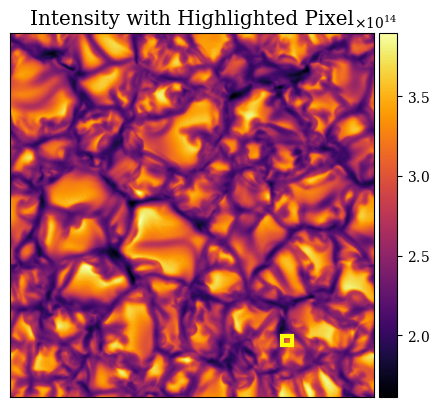

In [25]:
test_x = 400
test_y = 360

print(f"test_x: {test_x}, test_y: {test_y}")

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the intensity (Stokes I) at the specified wavelength pixel
data = stokes[..., 0, 0]
im = ax.imshow(data, cmap='inferno')

# Add a thick black rectangle to highlight the selected pixel
rect = patches.Rectangle((test_y - 1.5, test_x - 1.5), 3*4, 3*4, linewidth=3, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Intensity with Highlighted Pixel")
plt.show()

In astronomical sciences, it is common practice to normalize all the presented spectra to the continuum so that you are able to visualize the general behaviour of the spectra independent of the instrument measuring it. For this, we will choose manually some continuum dots.

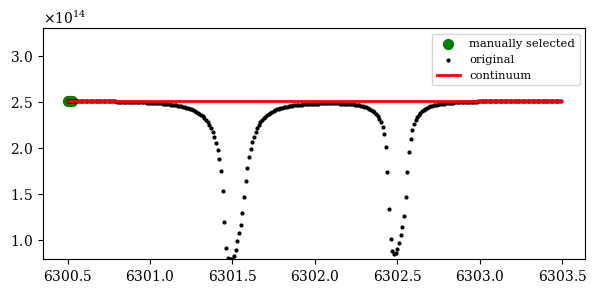

In [26]:
#Selection of the indices that we assume generally correspond to continuum in our data.
cont_indices = [0,1,2,3]


wl_cont_values = wl[cont_indices] #corresponding wavelength values to the selected continuum indices
cont_values = stokes[test_x, test_y,cont_indices,0] #corresponding intensity values to the selected continuum indices

cont_model = np.ones_like(wl)*np.mean(cont_values)

fig, ax = plt.subplots(figsize = (7,3))
ax.scatter(wl_cont_values, cont_values, label = "manually selected", color = "green", s = 50)
ax.scatter(wl, stokes[test_x, test_y, :, 0], label = "original", color = "black", s = 4)
ax.plot(wl, cont_model, label="continuum", color = "red")
ymin = np.min(stokes[test_x, test_y,:,0])
ymax = np.max(stokes[test_x, test_y,:,0])
ax.set_ylim((ymin, ymax+ymin))
ax.legend()
fig.savefig(images_output / "continuum_interpolation.png", dpi=300)
plt.show()

Let's create a function for doing it independent of the size of our spectral cube for our respective surface.

In [27]:
def continuum_normalization(spectral_cube: np.ndarray) -> np.ndarray:
    """
    Function to normalize the spectral cube by continuum normalization.
    Args:
        spectral_cube(np.ndarray): Spectral cube to be normalized.
    Returns:
        (np.ndarray) Normalized spectral
    """
    cont_indices = [0,1,2,3]

    # Vectorized interpolation for speedup
    # cont_values = spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()  # corresponding intensity values to the selected continuum indices
    # cont_model = interp1d(wl_cont_values, cont_values, kind="linear", axis=2)  # Interpolation applied over the assumed continuum values
    I_c =  spectral_cube[:, :, cont_indices, 0].mean(axis = 2).flatten().mean()
    # Apply the normalization
    norm_spectral_cube = np.zeros_like(spectral_cube)
    #mean_continuum_image = cont_model(wl_array).mean(axis=2)
    mean_continuum_image = spectral_cube[:, :, cont_indices, 0].mean(axis = 2)
    for i in range(spectral_cube.shape[-1]):
        norm_spectral_cube[..., i] = spectral_cube[..., i]/ I_c

    mean_continuum_image /= I_c
    return norm_spectral_cube, mean_continuum_image

In [28]:
norm_stokes, mean_continuum = continuum_normalization(stokes)
old_mean_continuum = mean_continuum.copy()

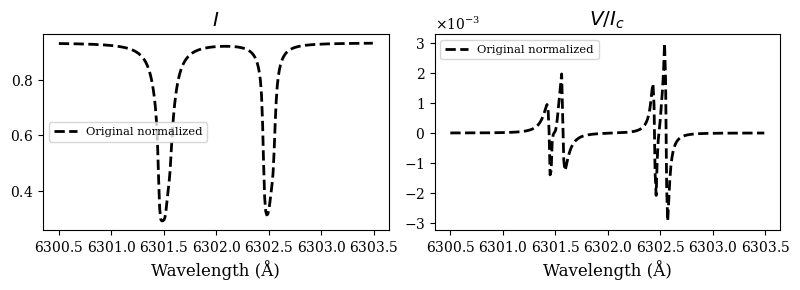

In [29]:
fig, ax = plt.subplots(1,2, figsize = (8,3))
stokes_titles = [r"$I$",r"$V/I_c$"]
for i in range(len(stokes_titles)):
    ax[i].plot(wl, norm_stokes[test_x, test_y, :, i], "--k", label="Original normalized")
    ax[i].set_title(stokes_titles[i])
    ax[i].set_xlabel("Wavelength (Å)")
    ax[i].legend()
    
fig.tight_layout()
plt.show()

## 4. Stokes Hinode/SOT-SP adaptation

Let's define a function for visualizing the total polarimetry for not taking just one wavelength point.

In [30]:
def check_overflow(data, name):
    """Check for NaN, inf values or extremely large numbers in data"""
    has_nan = np.isnan(data).any()
    has_inf = np.isinf(data).any()
    has_huge = (np.abs(data) > 1e30).any()
    
    if has_nan or has_inf or has_huge:
        print(f"WARNING: {name} has problems:")
        print(f"  - NaN values: {has_nan}")
        print(f"  - Inf values: {has_inf}")
        print(f"  - Extremely large values: {has_huge}")
        
        if has_nan:
            print(f"  - NaN count: {np.isnan(data).sum()}")
        if has_inf:
            print(f"  - Inf count: {np.isinf(data).sum()}")
        if has_huge:
            huge_vals = data[np.abs(data) > 1e30]
            print(f"  - Huge values: {huge_vals[:5]} ...")
        
        return True
    return False
def spectropolarimetry(stokes: np.ndarray) -> np.ndarray:
    """
    Function to calculate the polarization degree and angle from the Stokes parameters.
    Args:
        stokes(np.ndarray): Array containing the Stokes parameters.
    Returns:
        (np.ndarray) Array containing the polarization degree and angle.
    """
    I, V = stokes[..., 0], stokes[..., 1]
    nwl_points = stokes.shape[-2]

    # Avoid division by zero
    epsilon = 1e-10
    I_safe = np.maximum(I, epsilon)
    
    circular_polarization = np.sum(np.abs(V)/I_safe, axis=-1) / nwl_points
    
    # Check for overflow
    check_overflow(circular_polarization, "circular_polarization")
    
    return circular_polarization

A common metric for analyzing the contrast in an image, that should be reduced when a PSF convolution is applied, is the RMS metric. Let's define a function for it

In [31]:
def rms_calculation(data: np.ndarray) -> float:
    return np.sqrt(np.mean((data - data.mean())**2))/data.mean()

Let's create the polarization information for the stokes without processing

In [32]:
old_norm_circular_polarization = spectropolarimetry(norm_stokes)

Let's create a function that is going to be useful for visualizing the mean continuum and polarization states through the different processing states.

In [33]:
def plot_polarizations(mean_continuum_data: np.ndarray, 
                       circular_polarization_data: np.ndarray,
                       rms: list[float, float, float] = None) -> None:
    """
    Function to plot the mean continuum, linear polarization, and circular polarization.
    Args:
        mean_continuum_data(np.ndarray): Array containing the mean continuum.
        linear_polarization_data(np.ndarray): Array containing the linear polarization.
        circular_polarization_data(np.ndarray): Array containing the circular polarization.
    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(2*4.3, 4.3))

    # Plot mean_continuum
    im1 = ax[0].imshow(mean_continuum_data, cmap='inferno')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    divider1 = make_axes_locatable(ax[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)

    # Plot old_norm_circular_polarization
    q_low, q_high= np.quantile(circular_polarization_data, [0.01, 0.99])
    im3 = ax[1].imshow(old_norm_circular_polarization, cmap="PiYG", vmin=q_low, vmax=q_high)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    divider3 = make_axes_locatable(ax[1])
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im3, cax=cax3)

    if rms:
        ax[0].set_title(f'Continuum (rms = {rms[0]:.2f})')
        ax[1].set_title(f'Circular Pol. (rms = {rms[1]:.2f})')
    else:
        ax[0].set_title('Continuum')
        ax[1].set_title('Circular Pol.')

    plt.tight_layout()
    plt.show()

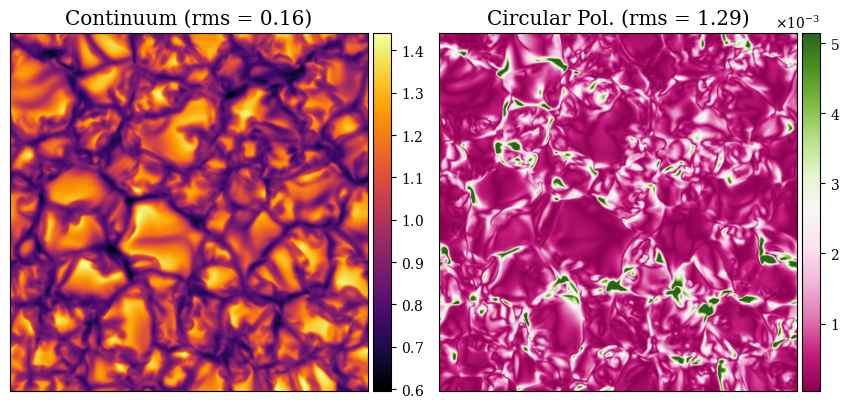

In [34]:
old_rms = [rms_calculation(old_mean_continuum), rms_calculation(old_norm_circular_polarization)]
plot_polarizations(mean_continuum, old_norm_circular_polarization, old_rms)

### 4.2 Degrading spectral resolution

In [35]:
lsf_hinode = pd.read_csv(ptm / "hinode-MODEST" / "PSFs" / "hinode_sp.spline.psf", sep = "\s+", header = None)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1376826/2396759674.py:1: SyntaxWarning: invalid escape sequence '\s'
  lsf_hinode = pd.read_csv(ptm / "hinode-MODEST" / "PSFs" / "hinode_sp.spline.psf", sep = "\s+", header = None)


In [36]:
lsf_wavelengths = lsf_hinode[0].values
lsf_values = lsf_hinode[1].values
lsf_interp = interp1d(lsf_wavelengths, lsf_values, kind = "cubic") 

lsf_wl_min = np.round(lsf_wavelengths.min()+0.010, 3)
lsf_wl_max = np.round(lsf_wavelengths.max()-0.010, 3)

step = wl[1] - wl[0]
new_kernel_wl = np.arange(lsf_wl_min, lsf_wl_max+step, step) #We are assuming that the values of the LSF are presented in amstrongs.
new_kernel_values = lsf_interp(new_kernel_wl)

print(f"LSF wavelengths range: {lsf_wl_min:0.3f} - {lsf_wl_max:0.3f}")


LSF wavelengths range: -0.060 - 0.060


Is important to normalize the LSF function for the signal to conserve its original energy

In [37]:
lsf_values = lsf_values / lsf_values.sum()
new_kernel_values = new_kernel_values / new_kernel_values.sum()

Convolve your stokes signal for each stokes on this lsf kernel

In [38]:
stokes_sptrl_convolved = np.zeros_like(stokes)

# Apply convolution for each Stokes parameter efficiently
for stk in tqdm(range(stokes.shape[-1])):
    stokes_sptrl_convolved[..., stk] = convolve1d(
        stokes[..., stk],               # Input: (nx, ny, n_lambda)
        weights=new_kernel_values,     # Kernel
        axis=-1,                       # Apply along wavelength axis
        mode='wrap'                    # Mimic periodic boundary as before
    )

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


In [39]:
norm_stokes_sptrl_convolved, mean_continuum_sptrl_convolved = continuum_normalization(stokes_sptrl_convolved)
circular_polarimetry_sptrl_convolved = spectropolarimetry(norm_stokes_sptrl_convolved)

Equivalent Width without LSF for the tested pixel: 0.24 Å
Equivalent Width with LSF for the tested pixel: 0.24 Å


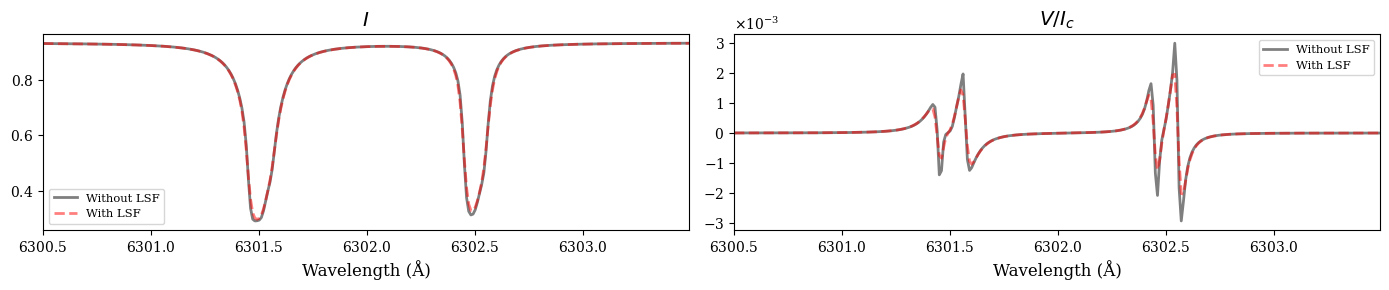

In [40]:
# Plot the Stokes parameters without the LSF and with the LSF
fig, ax = plt.subplots(1, 2, figsize=(2*7, 3))

# Normalize the spectrally convolved data for visualization
norm_stokes_sptrl_convolved, _ = continuum_normalization(stokes_sptrl_convolved)

for i in range(len(stokes_titles)):
    ax[i].plot(wl, norm_stokes[test_x, test_y, :, i], "k", label="Without LSF", linewidth=2, alpha=0.5)
    ax[i].plot(wl, norm_stokes_sptrl_convolved[test_x, test_y, :, i], "--r", label="With LSF", linewidth=2, alpha=0.5)
    ax[i].set_title(stokes_titles[i])
    ax[i].set_xlabel("Wavelength (Å)")
    ax[i].set_xlim(wl.min(), wl.max())
    ax[i].legend()

# Calculate Equivalent Width for Stokes I without LSF
continuum_level = stokes[test_x, test_y, :, 0].max()
equivalent_width_without_lsf = np.trapz(1 - stokes[test_x, test_y, :, 0] / continuum_level, wl)
print(f"Equivalent Width without LSF for the tested pixel: {equivalent_width_without_lsf:.2f} Å")

# Calculate Equivalent Width for Stokes I with LSF
continuum_level_convolved = stokes_sptrl_convolved[test_x, test_y, :, 0].max()
equivalent_width_with_lsf = np.trapz(1 - stokes_sptrl_convolved[test_x, test_y, :, 0] / continuum_level_convolved, wl)
print(f"Equivalent Width with LSF for the tested pixel: {equivalent_width_with_lsf:.2f} Å")

fig.tight_layout(w_pad=1.0, h_pad=2)
plt.show()

### 4.3 Spectral smpling

The spectral resolution on satellites doing spectropolarimetric measurements on the sun has, at best, 112 points of spectral resolution. This is the case for Hinode/SOT-SP, where the instrument information state in [Lites et al. 2013 (Solar Physics, 283, 579–599)](https://link.springer.com/article/10.1007/s11207-012-0206-3) that 
In this key paper (and related instrument papers), it's stated:

The Hinode/SP observes a spectral window centered near 6302 Å, specifically chosen to include:
- Fe I 6301.5 Å
- Fe I 6302.5 Å

The sampling is about 21.5 mÅ per pixel, covering 112 wavelength points, giving approximately 2.4 Å total range.

In [41]:
# Parameters from Hinode/SP FITS header (typical values)
NAXIS1 = 112
CRVAL1 = 6302.0    # Ångstroms
CDELT1 = 0.0215    # Å/pixel
CRPIX1 = 57        # Reference pixel

# Wavelength array calculation
new_wl = CRVAL1 + (np.arange(1, NAXIS1 + 1) - CRPIX1) * CDELT1

print("Interpolating Stokes parameters to Hinode/SP wavelengths...")
# Reshape stokes array for vectorized interpolation
stokes_reshaped = stokes_sptrl_convolved.reshape(-1, stokes_sptrl_convolved.shape[2], stokes_sptrl_convolved.shape[3])

# Create an array to store the interpolated values
stokes_to_hinode_wl = np.zeros((nx, ny, NAXIS1, stokes_sptrl_convolved.shape[-1]))
print(new_wl)
# Perform vectorized interpolation
for stk in tqdm(range(stokes_sptrl_convolved.shape[-1])):
    stokes_sptrl_interp = interp1d(wl, stokes_reshaped[:, :, stk], kind="cubic", axis=1)
    stokes_to_hinode_wl[..., stk] = stokes_sptrl_interp(new_wl).reshape(nx, ny, NAXIS1)

print("Interpolation finished!")


Interpolating Stokes parameters to Hinode/SP wavelengths...
[6300.796  6300.8175 6300.839  6300.8605 6300.882  6300.9035 6300.925
 6300.9465 6300.968  6300.9895 6301.011  6301.0325 6301.054  6301.0755
 6301.097  6301.1185 6301.14   6301.1615 6301.183  6301.2045 6301.226
 6301.2475 6301.269  6301.2905 6301.312  6301.3335 6301.355  6301.3765
 6301.398  6301.4195 6301.441  6301.4625 6301.484  6301.5055 6301.527
 6301.5485 6301.57   6301.5915 6301.613  6301.6345 6301.656  6301.6775
 6301.699  6301.7205 6301.742  6301.7635 6301.785  6301.8065 6301.828
 6301.8495 6301.871  6301.8925 6301.914  6301.9355 6301.957  6301.9785
 6302.     6302.0215 6302.043  6302.0645 6302.086  6302.1075 6302.129
 6302.1505 6302.172  6302.1935 6302.215  6302.2365 6302.258  6302.2795
 6302.301  6302.3225 6302.344  6302.3655 6302.387  6302.4085 6302.43
 6302.4515 6302.473  6302.4945 6302.516  6302.5375 6302.559  6302.5805
 6302.602  6302.6235 6302.645  6302.6665 6302.688  6302.7095 6302.731
 6302.7525 6302.774  6302

100%|██████████| 2/2 [00:04<00:00,  2.36s/it]

Interpolation finished!


The interpolated values compared to what we had before looks as the following plot

In [42]:
norm_stokes_to_hinode_wl, mean_continuum_stokes_to_hinode_wl = continuum_normalization(stokes_to_hinode_wl)
circular_polarimetry_to_hinode_wl = spectropolarimetry(norm_stokes_to_hinode_wl)

0.19849158798321032 0.19882121233837777


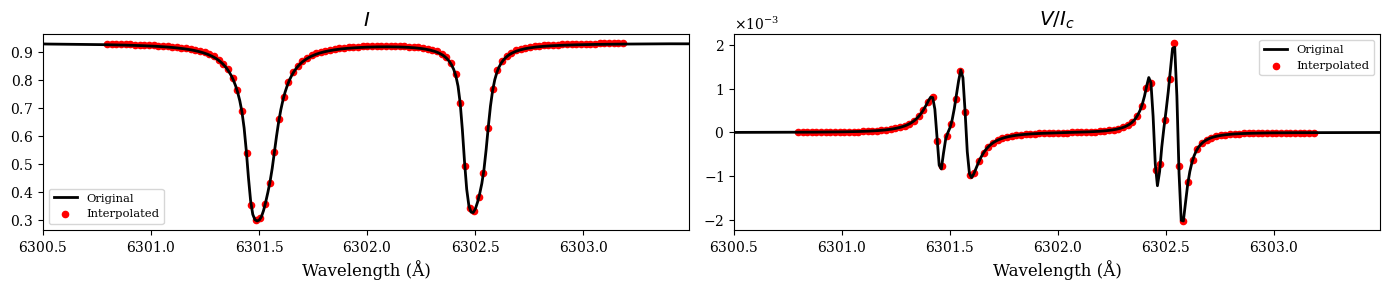

In [43]:
# Plot the previous Stokes parameters
fig, ax = plt.subplots(1, 2, figsize=(2*7, 3))

for i in range(len(stokes_titles)):
    ax[i].plot(wl, norm_stokes_sptrl_convolved[test_x, test_y, :, i], "k", label="Original")
    ax[i].scatter(new_wl, norm_stokes_to_hinode_wl[test_x, test_y, :, i], s=20, color="red", label="Interpolated")
    ax[i].set_title(stokes_titles[i])
    ax[i].set_xlabel("Wavelength (Å)")
    ax[i].set_xlim(wl.min(), wl.max())
    ax[i].legend()

fig.tight_layout(w_pad=1.0, h_pad=2)
fig.savefig(images_output / "stokes_comparison_plot.png", dpi=300)

print(norm_stokes_sptrl_convolved[...,1].max(), norm_stokes_to_hinode_wl[...,1].max())
plt.show()


### 4.4 Add some noise

Hinode data has, according to the paper of MODEST, $\sigma \approx  5.9 \times 10^{-4}\,I_c$. Let's add this noise to the our data.

In [44]:
# Add Gaussian noise to the resampled Stokes cube
I_c = mean_continuum_stokes_to_hinode_wl.flatten().mean()
level_of_noise = 5.9e-4 * I_c

norm_stokes_with_noise = np.zeros_like(norm_stokes_to_hinode_wl)
mean_continuum_with_noise = np.zeros_like(mean_continuum_stokes_to_hinode_wl)


for jx in tqdm(range(stokes_to_hinode_wl.shape[0])):
    for jy in range(stokes_to_hinode_wl.shape[1]):
        for stk in range(stokes_to_hinode_wl.shape[-1]):
            new_points = int(np.random.poisson(1))
            norm_stokes_with_noise[jx, jy, :, stk] = norm_stokes_to_hinode_wl[jx, jy, :, stk] + level_of_noise * I_c * np.random.randn(NAXIS1)
            mean_continuum_with_noise[jx,jy] = mean_continuum_stokes_to_hinode_wl[jx,jy] + level_of_noise * I_c * np.random.randn(1)[0]

  0%|          | 0/480 [00:00<?, ?it/s]

100%|██████████| 480/480 [00:03<00:00, 127.07it/s]


In [45]:
circular_polarization_with_noise = spectropolarimetry(norm_stokes_with_noise)

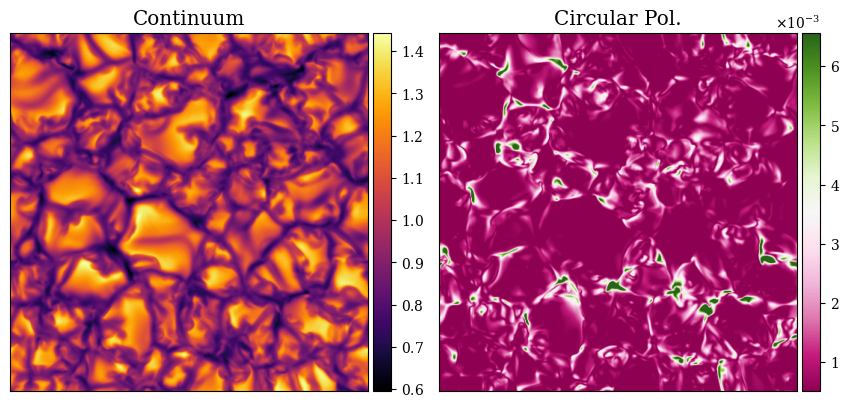

In [46]:
plot_polarizations(mean_continuum_with_noise, circular_polarization_with_noise)

### 4.6 Checking changes after processing

Let's see how our Stokes looked before the Hinode adaptation and after all the hinode processing.

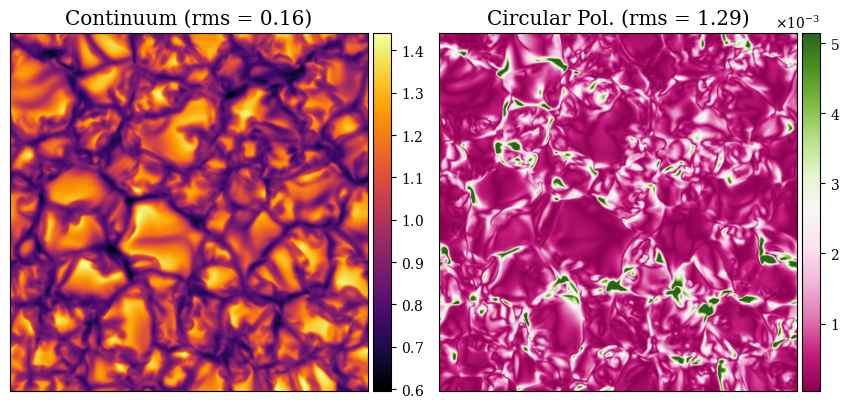

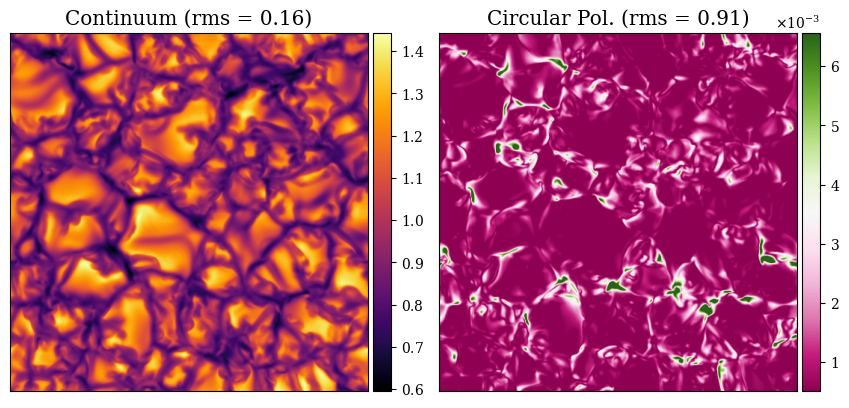

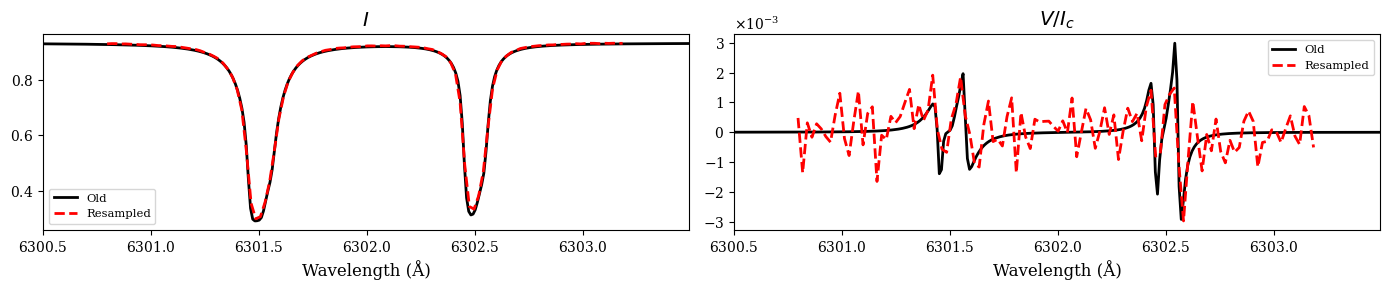

In [47]:
plot_polarizations(mean_continuum, old_norm_circular_polarization, old_rms)
rms_with_noise  = [rms_calculation(mean_continuum_with_noise),  rms_calculation(circular_polarization_with_noise)]
plot_polarizations(mean_continuum_with_noise, circular_polarization_with_noise, rms_with_noise)

# Define the pixel to be plotted
pixel_x, pixel_y = test_x, test_y

# Convert pixel coordinates to the new resampled size
fig, ax = plt.subplots(1, 2, figsize=(7*2, 3))
# Plot the spectral plots for the selected pixel
for i in range(len(stokes_titles)):
    ax[i].plot(wl, norm_stokes[pixel_x, pixel_y, :, i], "k", label="Old")
    ax[i].plot(new_wl, norm_stokes_with_noise[test_x, test_y, :, i], "--r", label="Resampled")
    ax[i].set_title(stokes_titles[i])
    ax[i].set_xlabel("Wavelength (Å)")
    ax[i].set_xlim(wl.min(), wl.max())
    ax[i].legend()

fig.tight_layout(w_pad=1.0, h_pad=0.001)
fig.savefig(images_output / "stokes_comparison_plot.png", dpi=300)
plt.show()


### 4.7 Calculate $B_\text{LOS}$ from Stokes

Let's check the continuum image an the circular polarization to check again the pixel we are observing that we are going to use to check the weak-field-approximation (WFA) inversion.

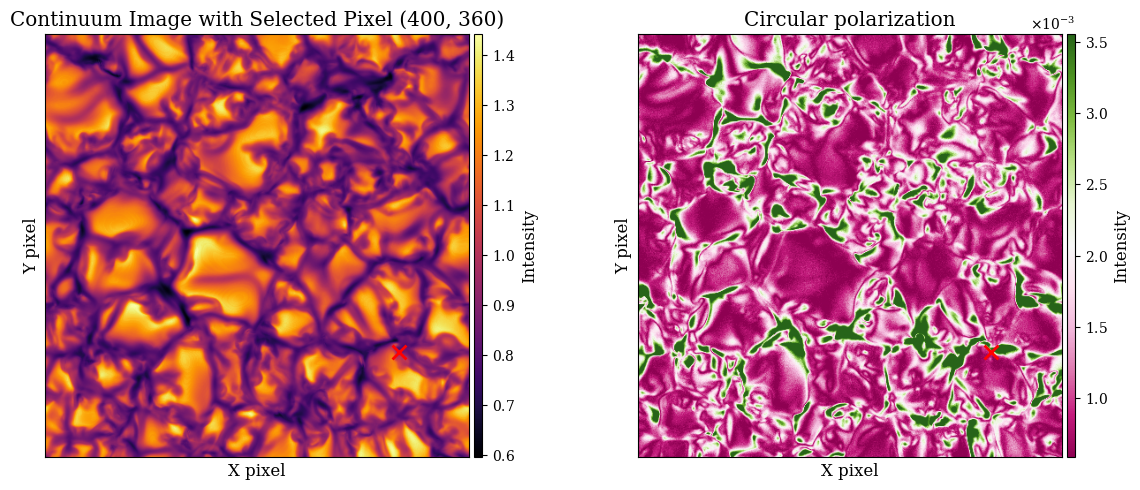

In [48]:
fig, ax = plt.subplots(1,2, figsize=(6*2,5))
ims = []
ims.append(ax[0].imshow(mean_continuum_with_noise, cmap='inferno'))
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(test_x,test_y, color='red', marker='x', s=100)  # Mark the pixel
ax[0].set_title(f'Continuum Image with Selected Pixel ({pixel_x}, {pixel_y})')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50
vmin, vmax = np.quantile(circular_polarization_with_noise, [0.05, 0.95])
ims.append(ax[1].imshow(circular_polarization_with_noise, cmap='PiYG', vmin=vmin, vmax=vmax))
ax[1].set_title('Circular polarization')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)

# Create proper sized colorbar
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('Intensity')

plt.tight_layout()

For the inversion we will only select the line at $6301.5\,\text{\AA}$.

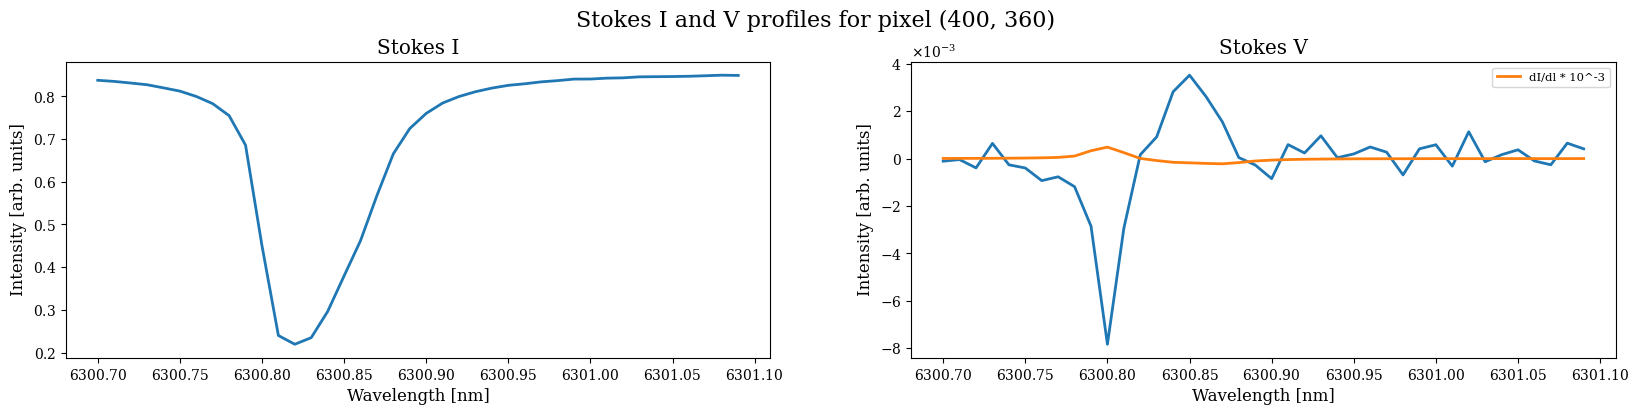

In [49]:
start_wl = 20
end_wl = 60
scale_constant = -(4.69E-13)* 6301.5**2.0 * 1.67 * 1.5

fig, ax = plt.subplots(1,2,figsize=(10*2,4))
# Set title for the entire figure
fig.suptitle(f'Stokes I and V profiles for pixel ({pixel_x}, {pixel_y})', fontsize=16)

# Ensure non-scientific notation for x-axis ticks
for a in ax:
    a.ticklabel_format(useOffset=False, style='plain', axis='x')
    
# Add some padding for the suptitle
plt.subplots_adjust(top=0.85)
ax[0].plot(wl[start_wl:end_wl], norm_stokes_with_noise[test_y, test_x,start_wl:end_wl,0])
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Intensity [arb. units]')
ax[0].set_title('Stokes I')
ax[1].plot(wl[start_wl:end_wl], norm_stokes_with_noise[test_y, test_x,start_wl:end_wl,-1])
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Intensity [arb. units]')
ax[1].set_title('Stokes V')
dI_dl = np.gradient(norm_stokes_with_noise[test_y, test_x,:,0]) / np.gradient(new_wl)
ax[1].plot(wl[start_wl:end_wl], dI_dl[start_wl:end_wl]*scale_constant, label='dI/dl * 10^-3')
ax[1].legend()
plt.show()
plt.close()

We will define a function for applying a fit for an overdetermined system using the WFA that follows
\begin{equation}
    V \approx -\frac{e}{4\pi m_e c} \cdot \lambda_0^2 \cdot g_{\lambda_0} \cdot B_{\text{LOS}} \frac{dI}{dl}
\end{equation}


In [50]:
def B_LOS_from_stokes(stokes:np.ndarray,
                      ll:np.ndarray,
                      start_ll:int,
                      end_ll:int,
                      llambda0:float,
                      g:float,
                      stokes_v_index:int):
    """
    Estimate the line-of-sight magnetic field from a data cube of Stokes I profiles.
    Args:
    stokes: numpy.ndarray
        3D data cube of Stokes I profiles
    ll: numpy.ndarray
        Wavelength axis in amstrongs
    start_ll: int
        Index of the starting wavelength range
    end_ll: int
        Index of the ending wavelength range
    llambda0: float
        Rest wavelength in amstrongs
    g: float
        Landé factor
    stokes_v_index: int
        Index of the Stokes V profile in the data cube
    Returns:
    numpy.ndarray
        2D map of the line-of-sight magnetic field in Gauss
    """
    wfa_constant = e.si / (4 * np.pi) / m_e / c
    wfa_constant = wfa_constant.to(1 / u.G / u.Angstrom )
    def estimate_B(dI_dl, V):
        ND = len(V)
        a = np.zeros([ND, 2])
        a[:, 0] = dI_dl[:]
        a[:, 1] = 1.0
        b = V[:]

        # Correct least-squares solution
        p = np.linalg.pinv(a) @ b / dI_dl.unit
        
        # Compute B_LOS
        B = -p[0]*u.Angstrom / (wfa_constant * (llambda0)**2.0 * g)
        return B
        
    NX = stokes.shape[0]
    NY = stokes.shape[1]

    B = np.zeros([NX,NY])

    for i in range (0,NX):
        for j in range(0,NY):
            dI_dl =  np.gradient(stokes[i,j,start_ll:end_ll,0]) / np.gradient(ll[start_ll:end_ll])
            local_B = estimate_B(dI_dl = dI_dl,
                                V = stokes[i,j,start_ll:end_ll,stokes_v_index])
            B[i,j] = local_B.value
    B = B * u.G
    
    return B

In [51]:
wfa_B_LOS = B_LOS_from_stokes(stokes = norm_stokes_with_noise, 
                                   ll = wl*u.Angstrom, 
                                   start_ll = start_wl, 
                                   end_ll = end_wl, 
                                   llambda0 = 6301.5*u.Angstrom, 
                                   g = 1.67,
                                   stokes_v_index = 1)

Let's check the magnetic field in the line-of-sight for both the inversion of the WFA and the original $B_{\text{LOS}}$. For doing this, we will calculate the relative root mean square error comparing with all optical depth heights.

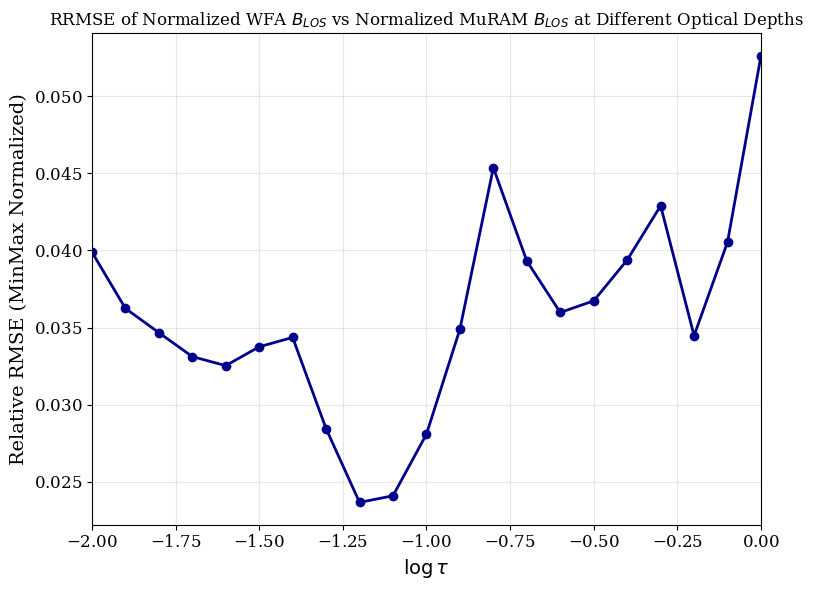

Minimum RRMSE (normalized): 0.0237 at log τ = -1.20
Maximum RRMSE (normalized): 0.0526 at log τ = 0.00
Mean RRMSE (normalized): 0.0358
Best matching height (normalized): log τ = -1.20 with RRMSE = 0.0237


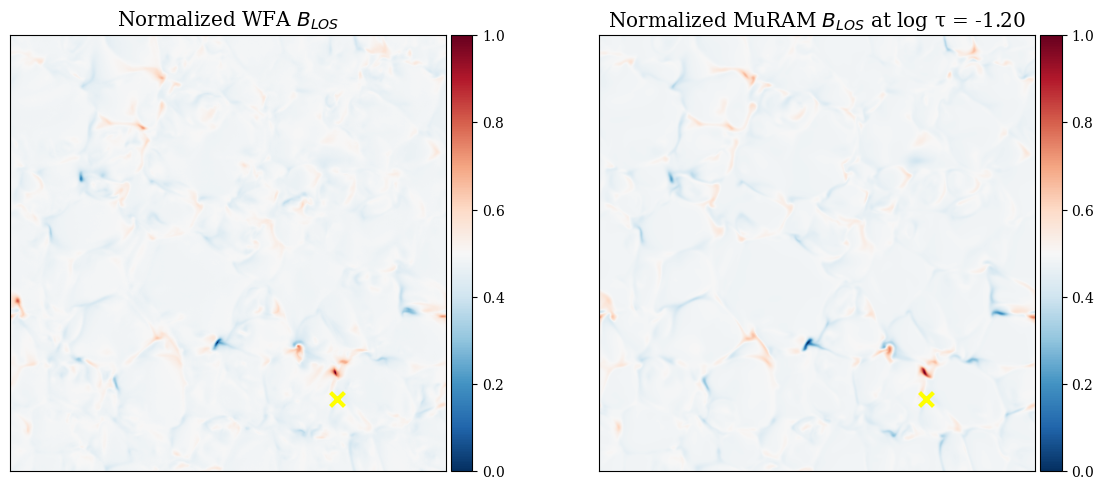


Normalized statistics comparison:
Normalized WFA B_LOS: mean = 0.485, std = 0.019
Normalized MuRAM B_LOS (best height): mean = 0.484, std = 0.020
Correlation coefficient (normalized): 0.835


In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

def relative_rmse(predicted, actual):
    """Calculate relative root mean square error using scikit-learn"""
    rmse = root_mean_squared_error(actual.flatten(), predicted.flatten())
    mean_actual = np.mean(np.abs(actual))
    return rmse / mean_actual if mean_actual != 0 else np.inf
# Initialize the scaler
scaler = MinMaxScaler()

# Convert wfa_B_LOS to numpy array for normalization
wfa_B_LOS_gauss = wfa_B_LOS.value

# Normalize wfa_B_LOS
wfa_B_LOS_normalized = scaler.fit_transform(wfa_B_LOS_gauss.reshape(-1, 1)).reshape(wfa_B_LOS_gauss.shape)

# Calculate RRMSE for each optical depth height with normalized data
rrmse_values_normalized = []

for height_idx in range(n_logtau):
    # Get magnetic field at this optical depth height (index 2 is B_LOS)
    muram_B_height = muram_box[:, :, height_idx, 2]
    
    # Normalize MuRAM B_LOS at this height
    muram_B_height_normalized = scaler.fit_transform(muram_B_height.reshape(-1, 1)).reshape(muram_B_height.shape)
    
    # Calculate RRMSE with normalized data
    rrmse = relative_rmse(wfa_B_LOS_normalized, muram_B_height_normalized)
    rrmse_values_normalized.append(rrmse)

# Create the plot with normalized data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(new_logtau, rrmse_values_normalized, 'o-', linewidth=2, markersize=6, color='darkblue')
ax.set_xlabel(r'$\log \tau$', fontsize=14)
ax.set_ylabel('Relative RMSE (MinMax Normalized)', fontsize=14)
ax.set_title('RRMSE of Normalized WFA $B_{LOS}$ vs Normalized MuRAM $B_{LOS}$ at Different Optical Depths', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(new_logtau.min(), new_logtau.max())

# Add some styling
ax.tick_params(labelsize=12)
plt.tight_layout()

# Save the plot
fig.savefig(images_output / "wfa_rrmse_vs_optical_depth_normalized.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"Minimum RRMSE (normalized): {np.min(rrmse_values_normalized):.4f} at log τ = {new_logtau[np.argmin(rrmse_values_normalized)]:.2f}")
print(f"Maximum RRMSE (normalized): {np.max(rrmse_values_normalized):.4f} at log τ = {new_logtau[np.argmax(rrmse_values_normalized)]:.2f}")
print(f"Mean RRMSE (normalized): {np.mean(rrmse_values_normalized):.4f}")

# Find the height with minimum RRMSE
min_rrmse_idx_normalized = np.argmin(rrmse_values_normalized)
min_rrmse_height_normalized = new_logtau[min_rrmse_idx_normalized]
best_muram_B_normalized = muram_box[:, :, min_rrmse_idx_normalized, 2]
best_muram_B_normalized_scaled = scaler.fit_transform(best_muram_B_normalized.reshape(-1, 1)).reshape(best_muram_B_normalized.shape)

print(f"Best matching height (normalized): log τ = {min_rrmse_height_normalized:.2f} with RRMSE = {rrmse_values_normalized[min_rrmse_idx_normalized]:.4f}")

# Create comparison plot with normalized data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot normalized WFA B_LOS
im1 = axes[0].imshow(wfa_B_LOS_normalized, cmap='RdBu_r', vmin=0, vmax=1)
axes[0].set_title(f'Normalized WFA $B_{{LOS}}$')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Add colorbar for WFA
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)

# Plot normalized MuRAM B_LOS at best matching height
im2 = axes[1].imshow(best_muram_B_normalized_scaled, cmap='RdBu_r', vmin=0, vmax=1)
axes[1].set_title(f'Normalized MuRAM $B_{{LOS}}$ at log τ = {min_rrmse_height_normalized:.2f}')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Add colorbar for MuRAM
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)

# Add test pixel markers
for ax in axes:
    ax.scatter(test_y, test_x, color='yellow', marker='x', s=100, linewidth=3)

plt.tight_layout()
fig.savefig(images_output / "wfa_vs_muram_comparison_normalized.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics for comparison
print(f"\nNormalized statistics comparison:")
print(f"Normalized WFA B_LOS: mean = {np.mean(wfa_B_LOS_normalized):.3f}, std = {np.std(wfa_B_LOS_normalized):.3f}")
print(f"Normalized MuRAM B_LOS (best height): mean = {np.mean(best_muram_B_normalized_scaled):.3f}, std = {np.std(best_muram_B_normalized_scaled):.3f}")
print(f"Correlation coefficient (normalized): {np.corrcoef(wfa_B_LOS_normalized.flatten(), best_muram_B_normalized_scaled.flatten())[0,1]:.3f}")

## 5. Using the DataCharger Class

Now let's demonstrate how to use the `DataCharger` class to process multiple files and prepare data for neural network training.

In [53]:
# Import the DataCharger class
import sys
sys.path.append('../modules_2')
from charge_data import DataCharger

# Example usage with multiple files
filenames = ["080000", "081000", "082000"]  # Add more filenames as needed

# Initialize the DataCharger
data_charger = DataCharger(
    data_path="/scratchsan/observatorio/juagudeloo/data",
    filenames=filenames,
    nx=480,
    ny=480,
    nz=256
)

# Charge all files (this will take some time)
# data_charger.charge_all_files()

# Get data information
# print(data_charger.get_data_info())

# Reshape for training
# stokes_training, muram_training = data_charger.reshape_for_training()

# Now you can use these arrays with PyTorch:
# stokes_tensor = torch.tensor(stokes_training, dtype=torch.float32)
# muram_tensor = torch.tensor(muram_training, dtype=torch.float32)

The `DataCharger` class provides:

1. **Automated processing**: All steps from the notebook are encapsulated in methods
2. **Multiple file handling**: Process batches of simulation files efficiently  
3. **Neural network ready**: Data is properly shaped for PyTorch training
4. **Consistent processing**: Same parameters and procedures applied to all files
5. **Memory efficient**: Processes files sequentially to manage memory usage

The final output shapes are:
- **Stokes data**: `(nx*ny*n_files, n_stokes, n_wavelengths)` - suitable for 1D CNN input
- **MuRAM data**: `(nx*ny*n_files, n_logtau*n_params)` - flattened atmospheric parameters for regression target

This format allows direct use with PyTorch DataLoader for training neural networks.

### 5.1 Charge one file

In [54]:
muram_box, stokes, wfa_blos_minmax, best_muram_B_minmax, _, min_rrmse_idx_normalized, min_rrmse_logtau = data_charger.charge_single_file(filename="112000")

Processing file: 112000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 167.64it/s]


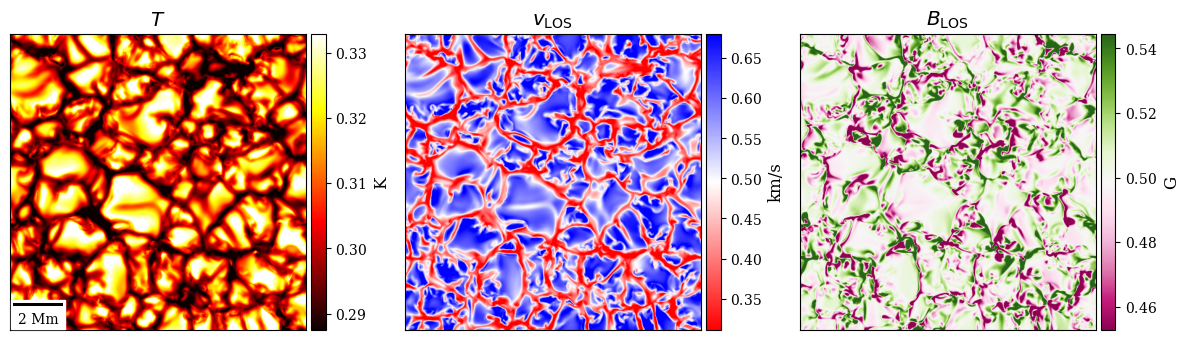

In [55]:
pixel_size_km = 25  # km per pixel
# Calculate the scale for the image
scale_bar = ScaleBar(pixel_size_km, "km", location="lower left")
quantities = [
    (0, r"$T$", "K", "hot"),
    (1, r"$v_{\text{LOS}}$", "km/s", "bwr_r"),
    (2, r"$B_{\text{LOS}}$", "G", "PiYG"),
]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    vmin, vmax = np.quantile(muram_box[...,-1,i], [0.05, 0.95])
    cmap = quantities[i][-1]
    im = ax[i].imshow(muram_box[...,-1,i], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(quantities[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].add_artist(scale_bar)  # Add scale bar to each subplot
    # Create divider and add colorbar with same height as subplot
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, label = quantities[i][2])

plt.tight_layout()
plt.show()


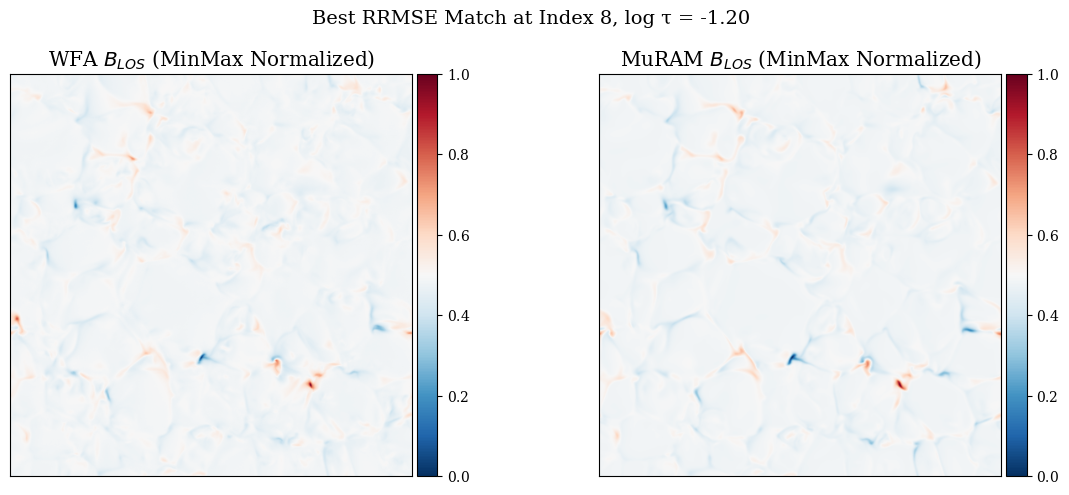

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot WFA B_LOS
im1 = axes[0].imshow(wfa_blos_minmax, cmap='RdBu_r', vmin=0, vmax=1)
axes[0].set_title('WFA $B_{LOS}$ (MinMax Normalized)')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot MuRAM B_LOS
im2 = axes[1].imshow(best_muram_B_minmax, cmap='RdBu_r', vmin=0, vmax=1)
axes[1].set_title('MuRAM $B_{LOS}$ (MinMax Normalized)')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Add colorbars with same height as subplots
for i, (ax, im) in enumerate(zip(axes, [im1, im2])):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

# Add suptitle with min_rrmse information
fig.suptitle(f'Best RRMSE Match at Index {min_rrmse_idx_normalized}, log τ = {min_rrmse_logtau:.2f}', fontsize=14)

plt.tight_layout()
plt.show()

In [57]:
_, mean_continuum = continuum_normalization(stokes)
circular_polarization = spectropolarimetry(stokes)

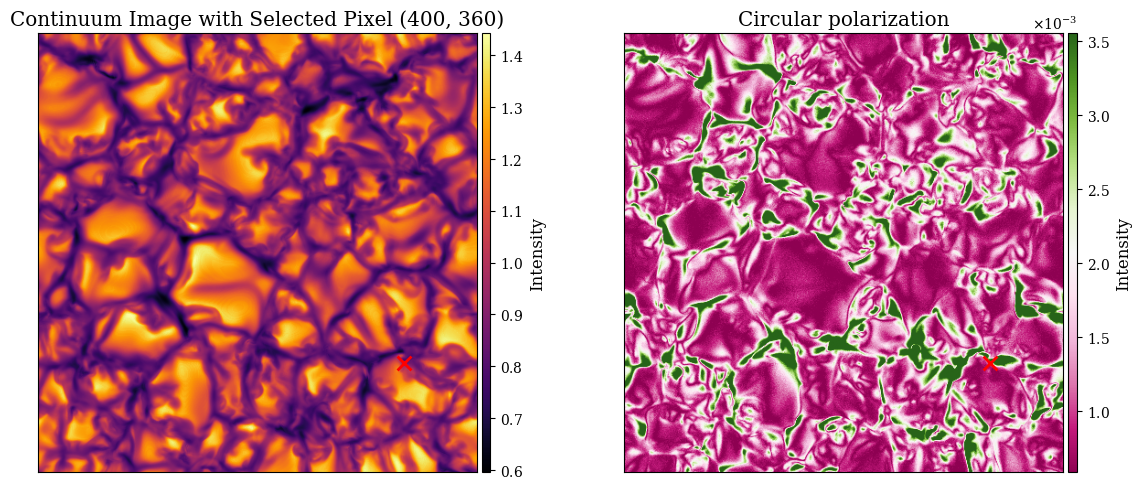

In [58]:
fig, ax = plt.subplots(1,2, figsize=(6*2,5))
ims = []
ims.append(ax[0].imshow(mean_continuum, cmap='inferno'))
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(test_x,test_y, color='red', marker='x', s=100)  # Mark the pixel
ax[0].set_title(f'Continuum Image with Selected Pixel ({pixel_x}, {pixel_y})')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50
vmin, vmax = np.quantile(circular_polarization, [0.05, 0.95])
ims.append(ax[1].imshow(circular_polarization, cmap='PiYG', vmin=vmin, vmax=vmax))
ax[1].set_title('Circular polarization')
ax[1].grid(False)

# Create proper sized colorbar
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('Intensity')

plt.tight_layout()


### 5.2 Charge various files data

In [59]:
data_charger.charge_all_files()

Charging 3 files...
Processing file: 080000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 167.59it/s]


Processing file: 081000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 167.42it/s]


Processing file: 082000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 167.56it/s]


Data charging completed!


{'080000': {'muram_box': array([[[[0.20317864, 0.47555617, 0.49995096],
           [0.20529309, 0.48111213, 0.49996723],
           [0.20765617, 0.48515852, 0.49998407],
           ...,
           [0.27914107, 0.60706596, 0.50403437],
           [0.29087075, 0.59711882, 0.5028421 ],
           [0.30271455, 0.57306042, 0.50184675]],
  
          [[0.20357344, 0.46979485, 0.49997107],
           [0.20559412, 0.47608923, 0.49999029],
           [0.20802772, 0.48085105, 0.50001004],
           ...,
           [0.27914734, 0.60171135, 0.5061192 ],
           [0.28646954, 0.59564172, 0.50649613],
           [0.29622831, 0.56646431, 0.50605877]],
  
          [[0.20394627, 0.46169495, 0.49999199],
           [0.20619259, 0.46806391, 0.50001478],
           [0.20872029, 0.47325576, 0.50003785],
           ...,
           [0.28095451, 0.58239059, 0.50629808],
           [0.28759203, 0.58095741, 0.50765806],
           [0.29483803, 0.5665585 , 0.50880444]],
  
          ...,
  
          [[0.202